<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Lilian/European_Call_jax_1stock_v3_BStest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use Black-Scholes to Generate Data

# Construct Neural Net

In [2]:
%%writefile cupy_dataset.py
import cupy
import numpy as np
from torch.utils.dlpack import from_dlpack
from scipy.stats import norm
from math import log, sqrt, pi, exp

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)    
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
def bs_delta(S,K,T,r,sigma):
    return norm.cdf(d1(S,K,T,r,sigma))

class OptionDataSet(object):
    
    def __init__(self, max_len, number_path, batch, seed, stocks):
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 50
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        self.T = 1.0 # assume T = 1, use float here
        self.seed = seed
        np.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration
        
        Y = cupy.zeros((self.N_BATCH, 1 + self.N_STOCKS), dtype=cupy.float32) # output: price, delta1, delta2, delta3
        X = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)

        for op in range(self.N_BATCH):

          ################################################################################################### generate random input numbers

          initial_stocks = np.array(0.75 + np.random.random(self.N_STOCKS) * 0.5)

          corr = np.diag(np.array([1]*self.N_STOCKS)) # assume no correlation between stocks here
          sigma = np.array(0.15 + np.random.random(self.N_STOCKS) * 0.3)
          cov = (np.diag(sigma)).dot(corr).dot(np.diag(sigma))

          r = np.repeat(np.array(0.25 + np.random.random(1) * 0.35), self.N_STOCKS)
          drift = r

          T = self.T
          K = 0.75 + np.random.random(1) * 0.5

          ###################################################################################################
          ################################################################################################### apply functions to compute price and deltas

          European_Call_price = bs_call(initial_stocks,K,T,r,sigma)
          Deltas = bs_delta(initial_stocks,K,T,r,sigma)

          ###################################################################################################
          ################################################################################################### store input and output numbers in X and Y

          Y[op, 0] = European_Call_price[0]
          Y[op, 1:4] = cupy.array(Deltas, dtype=cupy.float32)

          # T, K, S, sigma, mu, r
          paras = (np.repeat(np.array(T), self.N_STOCKS), np.repeat(np.array(K), self.N_STOCKS), initial_stocks, sigma, drift, r)
          paras = np.column_stack(paras).reshape(1,-1)[0]
          X[op,] = cupy.array(paras)

          ###################################################################################################

        self.num += 1
        return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))



# ds = OptionDataSet(max_len = 2, number_path = 1000000, batch = 2, seed = np.random.randint(10000), stocks=1) # for testing purpose, use constant seed. When training, change to random seed
# for i in ds:
#     print(i)

Overwriting cupy_dataset.py


In [3]:
%%writefile model.py
# version 1,2
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6*1, 32) # remember to change this!
        self.bnm1 = nn.BatchNorm2d(6)
        self.fc2 = nn.Linear(32, 64)
        self.bnm2 = nn.BatchNorm2d(6)
        self.fc3 = nn.Linear(64, 128)
        self.bnm3 = nn.BatchNorm2d(6)
        self.fc4 = nn.Linear(128, 64)
        self.bnm4 = nn.BatchNorm2d(6)
        self.fc5 = nn.Linear(64, 32)
        self.bnm5 = nn.BatchNorm2d(6)
        self.fc6 = nn.Linear(32, 1) # 1 outputs: price
        self.bnm6 = nn.BatchNorm2d(6)
        self.register_buffer('norm',
                             torch.tensor([1.0, 0.5, 0.5, 0.3, 0.35, 0.35]*1)) # don't use numpy here - will give error later
                                                                               # T, K, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = (x - torch.tensor([0.0, 0.75, 0.75, 0.15, 0.25, 0.25]*1).cuda()) / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


# Train Neural Net

In [4]:
!pip install pytorch-ignite

     |████████████████████████████████| 240 kB 5.2 MB/s 


In [5]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-2)
dataset = OptionDataSet(max_len = 100, number_path = 100000, batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)

    def compute_deltas(x):
      inputs = x
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    adjusted_y2 = (1000 * y)**2
    loss_weight = 1/adjusted_y2.mean(axis=0)
    loss_weight_normalized = loss_weight/loss_weight.sum()
    
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter) # print by multiplying 10000 -> easier to read (actual loss function isn't amplified)
        
trainer.run(dataset, max_epochs = 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: /usr/local/lib/python3.7/dist-packages/ignite/contrib/handlers/param_scheduler.py has been moved to /ignite/handlers/param_scheduler.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  if __name__ == '__main__':


loss 0.1838681697845459 average time 0.07644414039998537 iter num 20
loss 0.18437454104423523 average time 0.054251225899975 iter num 40
loss 0.1403898000717163 average time 0.04610064500000135 iter num 60
loss 0.1276060789823532 average time 0.042346469862525285 iter num 80
loss 0.14807458221912384 average time 0.03982833324000694 iter num 100
loss 0.08930030465126038 average time 0.031148369499987894 iter num 20
loss 0.1039464920759201 average time 0.030433939599970473 iter num 40
loss 0.0704348161816597 average time 0.030583052649960033 iter num 60
loss 0.06304951757192612 average time 0.03045377734998169 iter num 80
loss 0.0744742676615715 average time 0.030478667559987117 iter num 100
loss 0.039339158684015274 average time 0.03128051484989101 iter num 20
loss 0.036699410527944565 average time 0.03121781379992399 iter num 40
loss 0.021255869418382645 average time 0.03080251256662147 iter num 60
loss 0.01796690747141838 average time 0.030711515887458064 iter num 80
loss 0.0165386777

State:
	iteration: 10000
	epoch: 100
	epoch_length: 100
	max_epochs: 100
	output: 0.00015908914792817086
	batch: <class 'tuple'>
	metrics: <class 'dict'>
	dataloader: <class 'cupy_dataset.OptionDataSet'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

**Save Model**

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import torch
model_save_name = 'jax_european_1stock_BStest_1111_v1.pth'
path = F"/content/drive/MyDrive/AFP Project/Lilian/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import torch
model_save_name = 'jax_european_1stock_BStest_1111_v1.pth'
path = F"/content/drive/MyDrive/AFP Project/Lilian/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'bnm1.weight', 'bnm1.bias', 'bnm1.running_mean', 'bnm1.running_var', 'bnm1.num_batches_tracked', 'fc2.weight', 'fc2.bias', 'bnm2.weight', 'bnm2.bias', 'bnm2.running_mean', 'bnm2.running_var', 'bnm2.num_batches_tracked', 'fc3.weight', 'fc3.bias', 'bnm3.weight', 'bnm3.bias', 'bnm3.running_mean', 'bnm3.running_var', 'bnm3.num_batches_tracked', 'fc4.weight', 'fc4.bias', 'bnm4.weight', 'bnm4.bias', 'bnm4.running_mean', 'bnm4.running_var', 'bnm4.num_batches_tracked', 'fc5.weight', 'fc5.bias', 'bnm5.weight', 'bnm5.bias', 'bnm5.running_mean', 'bnm5.running_var', 'bnm5.num_batches_tracked', 'fc6.weight', 'fc6.bias', 'bnm6.weight', 'bnm6.bias', 'bnm6.running_mean', 'bnm6.running_var', 'bnm6.num_batches_tracked'])


In [19]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=6, out_features=32, bias=True)
  (bnm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (bnm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (bnm3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bnm4): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (bnm5): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=32, out_features=1, bias=True)
  (bnm6): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


**Continue to train model**

In [20]:
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
#dataset = OptionDataSet(max_len = 100, number_path = 1024, batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed
dataset = OptionDataSet(max_len = 100, number_path = 1000000, batch = 16, seed = np.random.randint(10000), stocks = 1) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)

    def compute_deltas(x):
      inputs = x
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    
    adjusted_y2 = (1000 * y)**2
    loss_weight = 1/adjusted_y2.mean(axis=0)
    loss_weight_normalized = loss_weight/loss_weight.sum()
    
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 10

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter) # print by multiplying 10000 -> easier to read (actual loss function isn't amplified)
        
trainer.run(dataset, max_epochs = 500)

model_save_name = 'jax_european_1stock_BStest_1111_v1.pth'
path = F"/content/drive/MyDrive/AFP Project/Lilian/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 6.785088044125587e-05 average time 0.018554522699923838 iter num 10
loss 1.1860920494655147e-05 average time 0.018069250949838533 iter num 20
loss 4.968382927472703e-05 average time 0.017468643166618374 iter num 30
loss 1.149070703831967e-05 average time 0.017693431499969846 iter num 40
loss 2.1644261778419605e-06 average time 0.017604520739951113 iter num 50
loss 1.1158632332808338e-05 average time 0.01733869203329353 iter num 60
loss 1.3274812772579025e-05 average time 0.01738729657135991 iter num 70
loss 1.136188529926585e-05 average time 0.017592441949932435 iter num 80
loss 4.05410974053666e-05 average time 0.017643064955498427 iter num 90
loss 2.2310272470349446e-05 average time 0.017695605239941868 iter num 100
loss 2.6352608983870596e-06 average time 0.01767332830004307 iter num 10
loss 7.422366252285428e-06 average time 0.017424549999986993 iter num 20
loss 4.369100679468829e-06 average time 0.01696528423329558 iter num 30
loss 4.7823610657360405e-05 average time 0.016695

#Results

In [21]:
import torch
inputs = torch.tensor([[1, 1, 1, 0.25, 0.3, 0.3]]).cuda() # T, K, S, sigma, mu, r
print('price: ' + str(model(inputs.float())))

inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient[0][[2]]

# price, delta
# should be around (0.27130044, 0.90763223)

price: tensor([[0.2710]], device='cuda:0', grad_fn=<AddmmBackward0>)


tensor([0.9078], device='cuda:0')

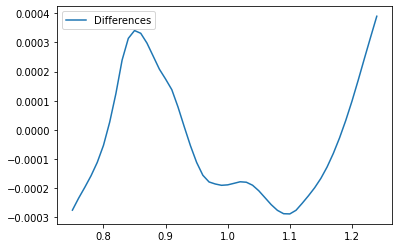

In [22]:
from scipy.stats import norm
from math import log, sqrt, pi, exp
import matplotlib.pyplot as plt

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)    
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))

def compute_price(S):
    inputs = torch.tensor([[1, 1, S, 0.25, 0.3, 0.3]]).cuda()
    return model(inputs.float())

prices = np.arange(0.75, 1.25, 0.01)
model_call_prices = []
BS_call_prices = []
for p in prices:
    model_call_prices.append(compute_price(p).item())
    BS_call_prices.append(bs_call(p, 1, 1, 0.3, 0.25))

#plt.plot(prices, model_call_prices, label = "model_call_prices")
#plt.plot(prices, BS_call_prices, label = "BS_call_prices")
plt.plot(prices, np.array(model_call_prices)-np.array(BS_call_prices), label = "Differences")
plt.legend()
plt.show()

# Delta

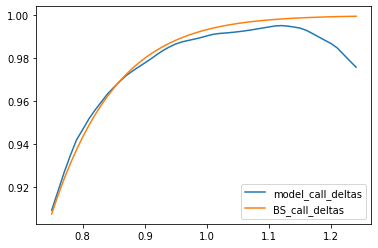

In [24]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 0.75, S, 0.25, 0.3, 0.3]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 0.75, 1, 0.3, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()